In [1]:
# The following notebook is based entirely on 
# this script from AGAMA: 
# https://github.com/GalacticDynamics-Oxford/Agama/blob/c507fc3e703513ae4a41bb705e171a4d036754a8/py/example_lmc_mw_interaction.py
import sys
sys.path.append('../')
import potential as potlib
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp

import diffrax
import fields as fields

import StreamSculptor
import potential
import matplotlib.pyplot as plt
import numpy as np
import jax
import RestrictedNbody
jax.config.update("jax_enable_x64", True)

from functools import partial
import interpax
from fields import integrate_field
# agama imports
import agama
import numpy as np, numpy

from InterpAGAMA import AGAMA_Spheroid

In [2]:
agama.setUnits(length=1, velocity=1, mass=1)  # work in units of 1 kpc, 1 km/s, 1 Msun)
timeUnitMyr = agama.getUnits()['time'] #agama time unit in Myr


In [3]:
4000./timeUnitMyr.value

np.float64(4.090848660171334)

In [4]:
### Below we start with the AGAMA setup. No jax in this cell.

Trewind = -14_000.0#-4000.0  # initial time [Myr] - the LMC orbit is computed back to that time
Tcurr   =  0.0  # current time
# heliocentric ICRS celestial coordinates and velocity of the LMC
# (PM from Luri+ 2021, distance from Pietrzynski+ 2019, center and velocity from van der Marel+ 2002)
ra, dec, dist, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
# transform to Galactocentric cartesian position/velocity, using built-in routines from Agama
# (hence the manual conversion factors from degrees to radians and from mas/yr to km/s/kpc)
l, b, pml, pmb = agama.transformCelestialCoords(agama.fromICRStoGalactic,
    ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist, pml*4.74, pmb*4.74, vlos)

# Create a simple but realistic model of the Milky Way with a bulge, a single disk,
# and a spherical dark halo
paramBulge = dict(
    type              = 'Spheroid',
    mass              = 1.2e10,
    scaleRadius       = 0.2,
    outerCutoffRadius = 1.8,
    gamma             = 0.0,
    beta              = 1.8)
paramDisk  = dict(
    type='MiyamotoNagai',
    mass              = 5.0e10,
    scaleRadius       = 3.0,
    scaleHeight       = 0.3)
paramHalo  = dict(
    type              = 'Spheroid',
    densityNorm       = 1.35e7,
    scaleRadius       = 14,
    outerCutoffRadius = 300,
    cutoffStrength    = 4,
    gamma             = 1,
    beta              = 3)
# Mass in spheroid is _total mass_
massLMC    = 1.5e11
radiusLMC  = (massLMC/1e11)**0.6 * 8.5
paramLMC = dict(
    type              = 'spheroid',
    mass              = massLMC,
    scaleRadius       = radiusLMC,
    outerCutoffRadius = radiusLMC*10,
    gamma             = 1,
    beta              = 3
    )
    

densMWhalo = agama.Density(paramHalo)
potMW      = agama.Potential(paramBulge, paramDisk, paramHalo)

# create a sphericalized MW potential and a corresponding isotropic halo distribution function
potMWsph   = agama.Potential(type='Multipole', potential=potMW, lmax=0, rmin=0.01, rmax=1000)
gmHalo     = agama.GalaxyModel(potMWsph,
    agama.DistributionFunction(type='quasispherical', density=densMWhalo, potential=potMWsph))

# compute the velocity dispersion in the MW halo needed for the dynamical friction
rgrid      = numpy.logspace(.01, 3, 32)
xyzgrid    = numpy.column_stack([rgrid, rgrid*0, rgrid*0])
sigma_eval  = gmHalo.moments(xyzgrid, dens=False, vel=False, vel2=True)[:,0]**0.5

# Create the LMC potential - a spherical truncated NFW profile with mass and radius
# related by the equation below, which produces approximately the same enclosed mass
# profile in the inner region, satisfying the observational constraints, as shown
# in Fig.3 of Vasiliev,Belokurov&Erkal 2021.
bminCouLog = radiusLMC * 2.0   # minimum impact parameter in the Coulomb logarithm
potLMC     = agama.Potential(paramLMC)

In [5]:
# Next we follow the steps below
# [Step 1]: Convert AGAMA potential to StreamSculptor Potentials
# [Step 2]: Convert dynamical friction sigmafnc (computed with AGAMA) to a jax interpolated array

# [Step 1]

pot_bulge_jax = AGAMA_Spheroid(**paramBulge)
pot_disk_jax = potential.MiyamotoNagaiDisk(m=paramDisk['mass'], a=paramDisk['scaleRadius'], b=paramDisk['scaleHeight'], units=usys)
pot_halo_jax = AGAMA_Spheroid(**paramHalo)
pot_MW_lst = [pot_bulge_jax, pot_disk_jax, pot_halo_jax]
pot_MW_jax = potential.Potential_Combine(pot_MW_lst, units=usys)

pot_LMC_jax = AGAMA_Spheroid(**paramLMC)

# [Step 2]
sigmafnc = interpax.Interpolator1D(x=rgrid, f=sigma_eval*(u.km/u.s).to(u.kpc/u.Myr), method='cubic2')



In [6]:
w0_test = jnp.array([10.0,20.0,15.0,0.1,.02,-0.02])
tsave_test = jnp.linspace(-4000, 0.0, 1000)

out_test_jax = pot_MW_jax.integrate_orbit(w0=w0_test, ts=tsave_test,solver=diffrax.Dopri8(),atol=1e-10,rtol=1e-10,dtmin=0.1)

w0_test_agama = numpy.hstack([w0_test[:3], w0_test[3:]*(u.kpc/u.Myr).to(u.km/u.s)])
agama_orb = agama.orbit(potential=potMW, ic=w0_test_agama, time=4000./timeUnitMyr.value,
                    timestart=-4000./timeUnitMyr.value, trajsize=1000)[1]

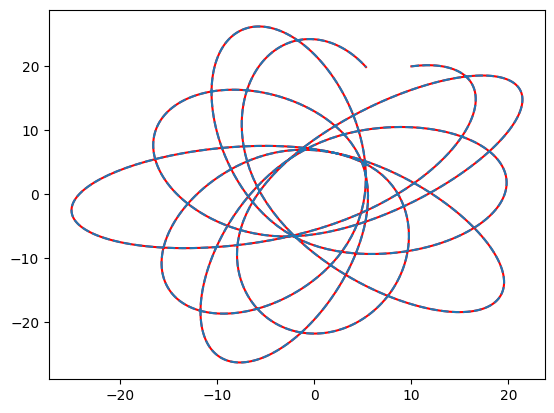

In [7]:
plt.plot(agama_orb[:,0], agama_orb[:,1], label='agama',color='r')
plt.plot(out_test_jax.ys[:,0], out_test_jax.ys[:,1], label='jax',ls='--')


In [8]:
sigmafnc(8.0)

Array(0.15297227, dtype=float64)

In [9]:
from fields import MW_LMC_field
field = MW_LMC_field(pot_MW=pot_MW_jax, pot_LMC=pot_LMC_jax, sigma_func=sigmafnc, bminCouLog=bminCouLog)

In [10]:
ICs_MW = jnp.zeros(6) # MW at origin at rest at t0
init_pos_LMC= np.hstack(posvelLMC)[:3]
init_vel_LMC= np.hstack(posvelLMC)[3:]*(u.km/u.s).to(u.kpc/u.Myr)
ICs_LMC = jnp.hstack([init_pos_LMC, init_vel_LMC])

ICs_total = [ICs_MW, ICs_LMC]
tsave = jnp.linspace(Trewind, Tcurr, 1_000)[::-1]
out = integrate_field(w0=ICs_total, ts=tsave, field=field, max_steps=10_000,solver=diffrax.Dopri5(),backwards_int=True)

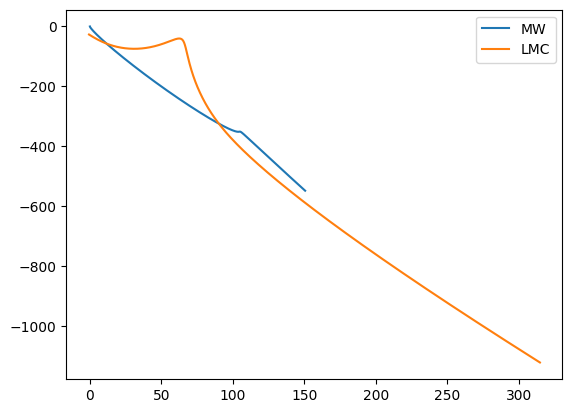

In [11]:
plt.plot(out.ys[0][:,0], out.ys[0][:,2], label='MW')
plt.plot(out.ys[1][:,0], out.ys[1][:,2], label='LMC')
plt.legend()

In [12]:
### next we will integrate in the frame of the MW. The track of the LMC in the MW frame is
### LMC position - MW position
trajLMC = out.ys[1][:,:3] - out.ys[0][:,:3]
flip_tsave = jnp.flip(tsave)
flip_trajLMC = jnp.flip(trajLMC, axis=0)


LMC_x = interpax.Interpolator1D(x=flip_tsave, f=flip_trajLMC[:,0], method='cubic2')
LMC_y = interpax.Interpolator1D(x=flip_tsave, f=flip_trajLMC[:,1], method='cubic2')
LMC_z = interpax.Interpolator1D(x=flip_tsave, f=flip_trajLMC[:,2], method='cubic2')

@jax.jit
def LMC_center_spline(t):
    return jnp.array([LMC_x(t), LMC_y(t), LMC_z(t)])

translating_LMC_pot = potential.TimeDepTranslatingPotential(pot=pot_LMC_jax, center_spl=LMC_center_spline,units=usys)

In [13]:
### In the non-inertial frame of the MW, there is a spatially uniform acceleration due to the MW's motion
### We need a velocity spline for the MW's motion to obtain the acceleration of its trajectory 
from potential import UniformAcceleration
### Fitting splines
flip_tsave = jnp.flip(tsave)
flip_traj = jnp.flip(out.ys[0], axis=0)
velocity_func_x = interpax.Interpolator1D(x=flip_tsave, f=flip_traj[:,3], method='cubic2')
velocity_func_y = interpax.Interpolator1D(x=flip_tsave, f=flip_traj[:,4], method='cubic2')
velocity_func_z = interpax.Interpolator1D(x=flip_tsave, f=flip_traj[:,5], method='cubic2')
@jax.jit
def velocity_func(t):
    return jnp.array([velocity_func_x(t), velocity_func_y(t), velocity_func_z(t)])

### Defining spatially uniform acceleration object. Can ultimately combine this with any potential object.
unif_acc = UniformAcceleration(velocity_func=velocity_func,units=usys)


In [14]:
###  Building the total potential
pot_total_lst = [pot_MW_jax, translating_LMC_pot, unif_acc]
pot_total = potential.Potential_Combine(pot_total_lst, units=usys)

### That's it!

In [15]:
pot_total.gradient(jnp.array([10.0,20.0,.1]),-1020.0)

Array([8.78946865e-04, 1.75289822e-03, 2.84123350e-05], dtype=float64)

In [16]:
pot_test = potential.MW_LMC_Potential(units=usys)

In [17]:
pot_test.acceleration(jnp.array([10.0,20.0,.1]),-1020.0)

Array([-8.78946865e-04, -1.75289822e-03, -2.84123350e-05], dtype=float64)

In [18]:
### Now let's compare the integrated orbit to the AGAMA implementation
import sys, agama, numpy, scipy.integrate, scipy.ndimage, scipy.special, matplotlib, matplotlib.pyplot as plt

agama.setUnits(length=1, velocity=1, mass=1)  # work in units of 1 kpc, 1 km/s, 1 Msun)

Trewind = -4.0  # initial time [Gyr] - the LMC orbit is computed back to that time
Tcurr   =  0.0  # current time
# heliocentric ICRS celestial coordinates and velocity of the LMC
# (PM from Luri+ 2021, distance from Pietrzynski+ 2019, center and velocity from van der Marel+ 2002)
ra, dec, dist, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
# transform to Galactocentric cartesian position/velocity, using built-in routines from Agama
# (hence the manual conversion factors from degrees to radians and from mas/yr to km/s/kpc)
l, b, pml, pmb = agama.transformCelestialCoords(agama.fromICRStoGalactic,
    ra * numpy.pi/180, dec * numpy.pi/180, pmra, pmdec)
posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist, pml*4.74, pmb*4.74, vlos)

# Create a simple but realistic model of the Milky Way with a bulge, a single disk,
# and a spherical dark halo
paramBulge = dict(
    type              = 'Spheroid',
    mass              = 1.2e10,
    scaleRadius       = 0.2,
    outerCutoffRadius = 1.8,
    gamma             = 0.0,
    beta              = 1.8)
paramDisk  = dict(
    type='MiyamotoNagai',
    mass              = 5.0e10,
    scaleRadius       = 3.0,
    scaleHeight       = 0.3)
paramHalo  = dict(
    type              = 'Spheroid',
    densityNorm       = 1.35e7,
    scaleRadius       = 14,
    outerCutoffRadius = 300,
    cutoffStrength    = 4,
    gamma             = 1,
    beta              = 3)
densMWhalo = agama.Density(paramHalo)
potMW      = agama.Potential(paramBulge, paramDisk, paramHalo)

# create a sphericalized MW potential and a corresponding isotropic halo distribution function
potMWsph   = agama.Potential(type='Multipole', potential=potMW, lmax=0, rmin=0.01, rmax=1000)
gmHalo     = agama.GalaxyModel(potMWsph,
    agama.DistributionFunction(type='quasispherical', density=densMWhalo, potential=potMWsph))

# compute the velocity dispersion in the MW halo needed for the dynamical friction
rgrid      = numpy.logspace(1, 3, 16)
xyzgrid    = numpy.column_stack([rgrid, rgrid*0, rgrid*0])
sigmafnc   = agama.Spline(rgrid, gmHalo.moments(xyzgrid, dens=False, vel=False, vel2=True)[:,0]**0.5)

# Create the LMC potential - a spherical truncated NFW profile with mass and radius
# related by the equation below, which produces approximately the same enclosed mass
# profile in the inner region, satisfying the observational constraints, as shown
# in Fig.3 of Vasiliev,Belokurov&Erkal 2021.
massLMC    = 1.5e11
radiusLMC  = (massLMC/1e11)**0.6 * 8.5
bminCouLog = radiusLMC * 2.0   # minimum impact parameter in the Coulomb logarithm
potLMC     = agama.Potential(
    type              = 'spheroid',
    mass              = massLMC,
    scaleradius       = radiusLMC,
    outercutoffradius = radiusLMC*10,
    gamma             = 1,
    beta              = 3)

######## PART ONE ########
# Simulate (approximately!) the past trajectory of the MW+LMC system under mutual gravity.
# Here, we integrate in time a 12-dimensional ODE system for positions & velocities of
# both galaxies in the external inertial reference frame. The acceleration of each galaxy
# is computed by taking the gradient of the rigid (non-deforming) potential of the other
# galaxy at the location of the first galaxy's center, and then assuming that the entire
# first galaxy experiences the same acceleration and continues to move as a rigid body.
# The same procedure then is applied in reverse. Moreover, we add a dynamical friction
# acceleration to the LMC, but not to the Milky Way; it is computed using the standard
# Chandrasekhar's formula, but with a spatially-varying value of Coulomb logarithm,
# which has been calibrated against full N-body simulations.
# This simplified model is certainly not physically correct, e.g. manifestly violates
# Newton's third law, but still captures the main features of the actual interaction.
print("Computing the past orbits of the Milky Way and the LMC")
def difeq(vars, t):
    x0    = vars[0:3]          # MW position
    v0    = vars[3:6]          # MW velocity
    x1    = vars[6:9]          # LMC position
    v1    = vars[9:12]         # LMC velocity
    dx    = x1-x0              # relative offset
    dv    = v1-v0              # relative velocity
    dist  = sum(dx**2)**0.5    # distance between the galaxies
    vmag  = sum(dv**2)**0.5    # magnitude of relative velocity
    f0    = potLMC.force(-dx)  # force from LMC acting on the MW center
    f1    = potMW .force( dx)  # force from MW acting on the LMC
    rho   = potMW.density(dx)  # actual MW density at this point
    sigma = sigmafnc(dist)     # approximate MW velocity dispersion at this point
    # distance-dependent Coulomb logarithm
    # (an approximation that best matches the results of N-body simulations)
    couLog= max(0, numpy.log(dist / bminCouLog)**0.5)
    X     = vmag / (sigma * 2**.5)
    drag  = -(4*numpy.pi * rho * dv / vmag *
        (scipy.special.erf(X) - 2/numpy.pi**.5 * X * numpy.exp(-X*X)) *
        massLMC * agama.G**2 / vmag**2 * couLog)   # dynamical friction force
    return numpy.hstack((v0, f0, v1, f1 + drag))

Tstep   = 1./100
tgrid   = numpy.linspace(Trewind, Tcurr, round((Tcurr-Trewind)/Tstep)+1)
ic      = numpy.hstack((numpy.zeros(6), posvelLMC))
sol     = scipy.integrate.odeint(difeq, ic, tgrid[::-1])[::-1]

# After obtaining the solution for trajectories of both galaxies,
# we transform it into a more convenient form, namely, into the non-inertial
# reference frame centered at the Milky Way center at all times.
# In this frame, the total time-dependent gravitational potential consists of
# three terms. First is the rigid potential of the Milky Way itself.
# Because the latter moves on a curvilinear trajectory, we need to add
# a corresponding spatially uniform acceleration field. Finally, the potential
# of the LMC is also rigid but moves in space.

# LMC trajectory in the MW-centric (non-inertial) reference frame
# (7 columns: time, 3 position and 3 velocity components)
trajLMC = numpy.column_stack([tgrid, sol[:,6:12] - sol[:,0:6]])
# MW trajectory in the inertial frame
trajMWx = agama.Spline(tgrid, sol[:,0], der=sol[:,3])
trajMWy = agama.Spline(tgrid, sol[:,1], der=sol[:,4])
trajMWz = agama.Spline(tgrid, sol[:,2], der=sol[:,5])
# MW centre acceleration is minus the second derivative of its trajectory in the inertial frame
accMW   = numpy.column_stack([tgrid, -trajMWx(tgrid, 2), -trajMWy(tgrid, 2), -trajMWz(tgrid, 2)])
potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
potLMCm = agama.Potential(potential=potLMC, center=trajLMC)  # potential of the moving LMC

# finally, the total time-dependent potential in the non-inertial MW-centric reference frame
potTotal= agama.Potential(potMW, potLMCm, potacc)


Computing the past orbits of the Milky Way and the LMC


In [19]:
Trewind, Tcurr

(-4.0, 0.0)

In [20]:
w0_test_agama = numpy.hstack([w0_test[:3], w0_test[3:]*(u.kpc/u.Myr).to(u.km/u.s)])
agama_orb = agama.orbit(potential=potTotal, ic=w0_test_agama, time=4000./timeUnitMyr.value,
                    timestart=-4000./timeUnitMyr.value, trajsize=1000)[1]

In [21]:
jax_orb = pot_total.integrate_orbit(w0=w0_test, ts=jnp.linspace(-4000,0,1000))

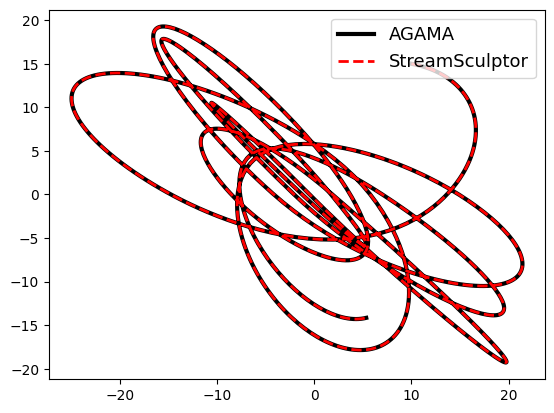

In [22]:
plt.plot(agama_orb[:,0],agama_orb[:,2],color='k',label='AGAMA',lw=3)
plt.plot(jax_orb.ys[:,0],jax_orb.ys[:,2],label='StreamSculptor',color='r',lw=2,ls='--')
plt.legend(fontsize=13,loc='upper right')



### Note, all of the above work is saved and stored in a MW-LMC potential function. See usage below

In [35]:
from potential import MW_LMC_Potential
# Intialization of this class takes a moment: all of the above splines are being fit (and with jit)
pot_MWLMC = MW_LMC_Potential(units=usys)


In [38]:
jax_orb = pot_MWLMC.integrate_orbit(w0=w0_test, ts=jnp.linspace(-4000,0,1000))

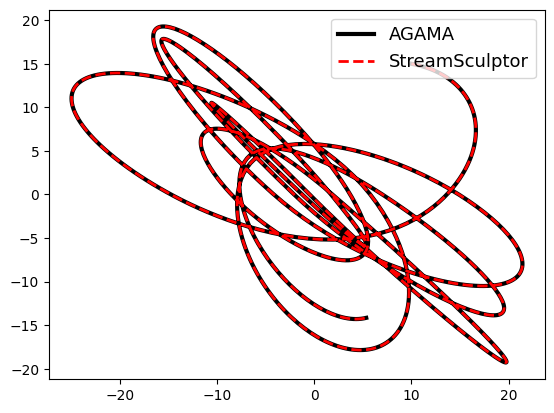

In [39]:
plt.plot(agama_orb[:,0],agama_orb[:,2],color='k',label='AGAMA',lw=3)
plt.plot(jax_orb.ys[:,0],jax_orb.ys[:,2],label='StreamSculptor',color='r',lw=2,ls='--')
plt.legend(fontsize=13,loc='upper right')

### Same as before. Though the script above allows one to experiment with changing parameters.
